# Gaussian Process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sympy 
from tqdm.notebook import tqdm
# plt.style.use('seaborn')

## Load data

In [2]:
def load_data(data_path):
    data = pd.read_csv(data_path + 'gp_x.csv', header=None)
    target = pd.read_csv(data_path + 'gp_t.csv', header=None)
    return data, target

DATA_DIR = '/content/drive/MyDrive/ColabNotebooks/Machine Learning/Gaussian Process/'
data, target = load_data(DATA_DIR)

# 題目要求使用前50筆資料當作 training data 
x_train, x_test, y_train, y_test = data.values[:50], data.values[50:], target.values[:50], target.values[50:]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50, 1) (50, 1)
(50, 1) (50, 1)


## 1-1 GaussianProcess Model

Please implement the GP with exponential-quadratic kernel function given by

$k(X_n, X_m) = \theta_0\exp(-\frac{\theta_1}{2}\lVert X_n - X_m \rVert^2) + \theta_2 + \theta_3X_n^T X_m$

In [3]:
class GaussianProcess:
    """thete is hyper-parameters for kernel function"""
    def __init__(self, theta, beta=1):
        self.theta = theta
        self.beta = beta
    
    def fit(self, X, y):
        self.sample_size, self.n_features = X.shape
        self.X = X
        self.y = y
    
    def predict(self, X):
        mean = []
        std = []
        for x in X:
           m, v = self._predict(x)
           mean.append(m.item())
           std.append(v)
        return np.array(mean), np.array(std)
    
    def _predict(self, x):
        """predict for singal data"""
        K = self.K(x)
        C = self.C()
        c = self.c(x)

        mean = (np.dot(K.T, np.linalg.inv(C))).dot(self.y)
        std = np.sqrt(c - np.dot(np.dot(K.T, np.linalg.inv(C)), K))

        return mean, std
    
    def K(self, x):
        """K為預測資料和所有訓練資料做成的kernel"""
        return np.array([self.exponential_quadratic(x, point, **self.theta) for point in self.X])
    
    def C(self):
        """計算訓練之間的相關性"""
        c = np.zeros((self.sample_size, self.sample_size))
        for n in range(self.sample_size):
            for m in range(self.sample_size):
                c[n, m] = self.exponential_quadratic(self.X[n], self.X[m], **self.theta) + self.beta**-1 * (1 if n==m else 0)
        return np.array(c)
    
    def c(self, x):
        """預測資料自己和自己做成的kernel"""
        return self.exponential_quadratic(x, x, **self.theta) + self.beta**-1

    @staticmethod
    def exponential_quadratic(xn, xm, *, t0, t1, t2, t3):
        """一次各一筆資料算kernel"""
        return t0 * np.exp(-0.5 * t1 * np.dot((xn-xm), (xn-xm))) + t2 + t3*np.dot(xn.T, xm)


## 1-2 Plot Prediction

Please plot the prediction result like Figure 6.8 of textbook for training set but one standard deviation instead of two and without the green curve. The title of the figure should be the value of the hyperparameters used in this model. The red line shows the mean m(·) of the GP predictive distribution. The pink region corresponds to plus and minus one standard deviation. Training data points are shown in blue. An example is provided in below.

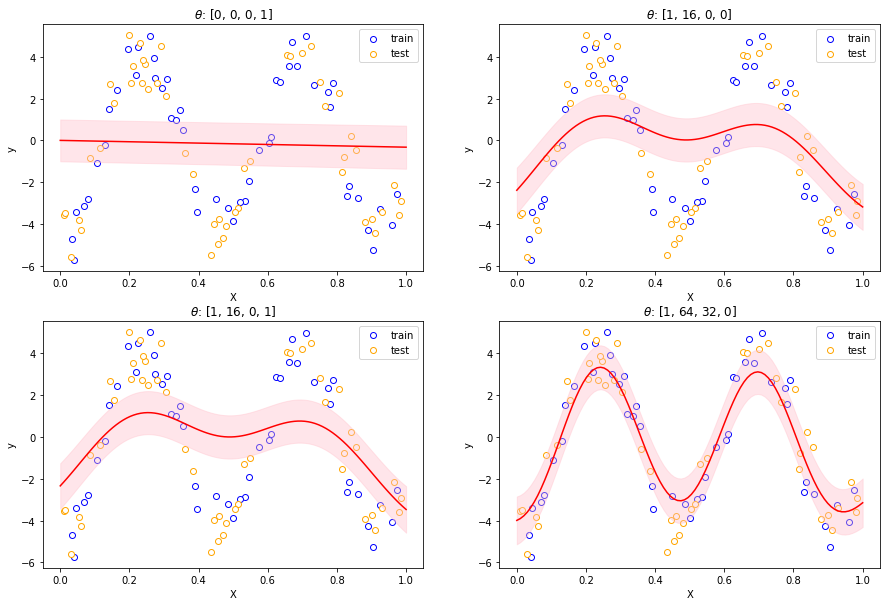

total run time: 18.799/s


In [4]:
start = time.time()

# 題目設定的hyper-parameters
theta = [
    {'t0':0, 't1':0, 't2':0, 't3':1},
    {'t0':1, 't1':16, 't2':0, 't3':0},
    {'t0':1, 't1':16, 't2':0, 't3':1},
    {'t0':1, 't1':64, 't2':32, 't3':0},
]
x = np.linspace(0, 1, 100).reshape(-1, 1)

fig, ax = plt.subplots(2, 2, figsize=(15,10))
position = [(0, 0), (0, 1), (1, 0), (1, 1)]
for t, p in zip(theta, position):
    model = GaussianProcess(theta=t) 
    model.fit(x_train, y_train)   
    mean, std = model.predict(x)

    # plt.figure(figsize=(8, 6)
    ax[p].scatter(x_train, y_train, c='w', edgecolors='b', label='train')
    ax[p].scatter(x_test, y_test, c='w', edgecolors='orange', label='test')
    ax[p].plot(x, mean, '-', c='r')
    ax[p].fill_between(x.flatten(), mean+std, mean-std, color='pink', alpha=0.4)
    ax[p].set_xlabel('X')
    ax[p].set_ylabel('y')
    ax[p].set_title(r'$\theta$: '+f'{list(t.values())}')
    ax[p].legend()
plt.savefig('GP.png')
plt.show()

end = time.time()
print(f'total run time: {end - start:.3f}/s')

## 1-3 Root-Mean Square Error

Show the corresponding root-mean-square errors

$E_{RMS} = \sqrt{\frac{1}{N} (m(x_n) - t_n)^2}$

In [5]:
def RMS(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

for t in theta:
    model = GaussianProcess(theta=t)
    model.fit(x_train, y_train)
    
    # train
    mean, _ = model.predict(x_train)
    rmstrain = RMS(y_train.flatten(), mean)

    # test
    mean, _ = model.predict(x_test)
    rmstest = RMS(y_test.flatten(), mean) 

    print(f'\u03B8: {list(t.values())}, training RMS {rmstrain:.3f}, testing RMS {rmstest:.3f}')

θ: [0, 0, 0, 1], training RMS 3.129, testing RMS 3.344
θ: [1, 16, 0, 0], training RMS 2.424, testing RMS 2.668
θ: [1, 16, 0, 1], training RMS 2.416, testing RMS 2.661
θ: [1, 64, 32, 0], training RMS 1.043, testing RMS 1.163


## 1-4 Automatic Relevance Determination

Try to tune the hyperparameters by yourself to find the best combination for the dataset. 

You can tune the hyperparameters by trial and error or use automatic relevance de- termination (ARD) in Chapter 6.4.4 of textbook. 

(If you implement the ARD method, you will get the bonus points.)

In [6]:
class Ard:
    def __init__(self, learning_rate=0.001, max_iter=1000):
        self.lr = learning_rate
        self.max_iter = max_iter
    
    def param_differential(self, model, *, t0, t1, t2, t3):
        dt0, dt1, dt2, dt3 = [np.empty((model.sample_size, model.sample_size)) for _ in range(4)]
        for n in range(model.sample_size):
            for m in range(model.sample_size):
                dt0[n, m] = np.exp(-0.5 * t1 * np.dot((model.X[n]-model.X[m]), (model.X[n]-model.X[m])))
                dt1[n, m] = t0 * np.exp(-0.5 * t1 * np.dot((model.X[n]-model.X[m]), (model.X[n]-model.X[m]))) * (-0.5 * np.dot((model.X[n]-model.X[m]), (model.X[n]-model.X[m])))
                dt2[n, m] = 1
                dt3[n, m] = np.dot(model.X[n], model.X[m])
        
        return dt0, dt1, dt2, dt3
    
    def updata_param(self, model):
        t0, t1, t2, t3 = model.theta.values()
        for _ in range(self.max_iter):
            dt0, dt1, dt2, dt3 = self.param_differential(model, **model.theta)
            t0 += self.lr * self.loglikelihood(model, dt0)
            t1 += self.lr * self.loglikelihood(model, dt1)
            t2 += self.lr * self.loglikelihood(model, dt2)
            t3 += self.lr * self.loglikelihood(model, dt3)
            model.theta = {'t0':t0.item(), 't1':t1.item(), 't2':t2.item(), 't3':t3.item()}

        return model.theta

    def loglikelihood(self, model, dtheta):
        c_inv = np.linalg.inv(model.C())
        return -0.5*np.trace(np.dot(c_inv, dtheta)) + \
            np.dot(0.5*np.dot(model.y.T, c_inv).dot(dtheta), c_inv).dot(model.y)

In [7]:
for t in tqdm(theta):
    optimizer = Ard(learning_rate=0.01, max_iter=1000)
    model = GaussianProcess(t)
    model.fit(x_train, y_train)
    
    # original RMS
    mean, _ = model.predict(x_train)
    rmstrain_old = RMS(y_train.flatten(), mean)
    mean, _ = model.predict(x_test)
    rmstest_old = RMS(y_test.flatten(), mean)
    
    # optimized RMS
    model.theta = optimizer.updata_param(model)
    optim_param = {f"{key}":round(model.theta[key], 3) for key in model.theta}
    mean, _ = model.predict(x_train)
    rmstrain = RMS(y_train.flatten(), mean)
    mean, _ = model.predict(x_test)
    rmstest = RMS(y_test.flatten(), mean) 

    print(f'initial \u03B8: {list(t.values())}, training RMS {rmstrain_old:.3f}, testing RMS {rmstest_old:.3f}')
    print(f'optimal \u03B8: {list(optim_param.values())}, training RMS {rmstrain:.3f}, testing RMS {rmstest:.3f}')

initial θ: [0, 0, 0, 1], training RMS 3.129, testing RMS 3.344
optimal θ: [16.793, 29.696, 1.532, 0.81], training RMS 0.798, testing RMS 1.034
initial θ: [1, 16, 0, 0], training RMS 2.424, testing RMS 2.668
optimal θ: [16.869, 33.085, 0.255, -0.354], training RMS 0.776, testing RMS 1.022
initial θ: [1, 16, 0, 1], training RMS 2.416, testing RMS 2.661
optimal θ: [16.888, 33.079, 0.236, 0.646], training RMS 0.776, testing RMS 1.022
initial θ: [1, 64, 32, 0], training RMS 1.043, testing RMS 1.163
optimal θ: [10.492, 64.845, 31.857, -0.273], training RMS 0.717, testing RMS 1.034

